## import Modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

## Read Data

In [80]:
# F_counter = Counter({f for chunk in pd.read_table('training-data-large.txt',header=None,chunksize=10000,names=['Class','Feat']) 
#                                                  for f_list in chunk.Feat.apply(lambda x : x.split(',')) 
#                                                  for f in f_list})

In [7]:
data = pd.read_table('training-data-small.txt',header=None,names=['Class', 'Features'])
# data = pd.read_table('test-data-small.txt',header=None)
# data = pd.read_table('training-data-large.txt',header=None)

In [8]:
F_counter= Counter([f for f_list in data.Features.apply(lambda x :x.split(',')) for f in f_list ])
X_counter= Counter([f for f_list in data.Features.apply(lambda x :x.split(',')) for f in f_list if f.startswith('X')])
Y_counter= Counter([f for f_list in data.Features.apply(lambda x :x.split(',')) for f in f_list if f.startswith('Y')])
Z_counter= Counter([f for f_list in data.Features.apply(lambda x :x.split(',')) for f in f_list if f.startswith('Z')])

print ('Number of Unique_features : {}'.format(len(F_counter.keys())))
print ('Number of X_features : {}'.format(len(X_counter.keys())))
print ('Number of Y_features : {}'.format(len(Y_counter.keys())))
print ('Number of Z_features : {}'.format(len(Z_counter.keys())))

Number of Unique_features : 125
Number of X_features : 50
Number of Y_features : 50
Number of Z_features : 25


In [4]:
feat2int = {feat : idx for idx , feat in enumerate(sorted(F_counter.keys()),1)}
int2feat = {idx : feat for idx , feat in enumerate(sorted(F_counter.keys()),1)}
feat2int['PAD'] = 0
int2feat[0]='PAD'

vocab_size = len(int2feat)

In [5]:
def start_with(feature_list,start_ch):
    count = 0
    for feature in feature_list:
        if feature.startswith(start_ch):
            count = count +1
    return count

In [6]:
def one_hot(f_list, word_num, start_ch = None):
    one_hot = np.zeros([word_num])
    for f in f_list:
        if start_ch == None:
            one_hot[f] = 1
        elif f.startswith(start_ch):            
            one_hot[feat2int.get(f)] = 1
    return one_hot.astype(int)

## Metric

In [7]:
data['Encoded_Feature'] = data.Features.apply(lambda x : [feat2int.get(feat) for feat in  x.split(',')])
data['Encoded_OneHot'] = data.Encoded_Feature.apply(lambda x : one_hot(x, len(F_counter)+1))
data['X_enc'] = data.Features.apply(lambda x : one_hot(x.split(','), vocab_size, start_ch='X'))
data['Y_enc'] = data.Features.apply(lambda x : one_hot(x.split(','), vocab_size, start_ch='Y'))
data['Z_enc'] = data.Features.apply(lambda x : one_hot(x.split(','), vocab_size, start_ch='Z'))
data['X_start'] = data.Features.apply(lambda x : start_with(x,'X'))
data['Y_start'] = data.Features.apply(lambda x : start_with(x,'Y'))
data['Z_start'] = data.Features.apply(lambda x : start_with(x,'Z'))
data['Feature_count'] = data.Features.apply(lambda x : len(x.split(',')))
data.head(1)

,Class,Features,Encoded_Feature,Encoded_OneHot,X_enc,Y_enc,Z_enc,X_start,Y_start,Z_start,Feature_count
0,0,"X773579,Y2640,Y2072,Z4,Z15","[48, 79, 72, 122, 104]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,2,2,5


In [8]:
enc = np.array(data.Encoded_OneHot.tolist(),dtype=float)
enc_X = np.array(data.X_enc.tolist(),dtype=float)
enc_Y= np.array(data.Y_enc.tolist(),dtype=float)
enc_Z = np.array(data.Z_enc.tolist(),dtype=float)
y = data.Class.values.reshape([-1,1]).astype(float)

enc, enc_test, \
enc_X, enc_X_test,\
enc_Y, enc_Y_test,\
enc_Z, enc_Z_test, \
y , y_test = train_test_split(enc ,enc_X,enc_Y,enc_Z,y,train_size = 0.66)

print('Shape of onehot: {}' .format(enc.shape))
print('Shape of x_onehot: {}' .format(enc_X.shape))
print('Shape of y_onehot: {}' .format(enc_Y.shape))
print('Shape of z_onehot: {}' .format(enc_Z.shape))
print('Shape of y: {}' .format(y.shape))

Shape of onehot: (6600, 126)
Shape of x_onehot: (6600, 126)
Shape of y_onehot: (6600, 126)
Shape of z_onehot: (6600, 126)
Shape of y: (6600, 1)


### There is no duplicate feature

In [9]:
(data.Features.apply(lambda x : len(set(x.split(',')))) == data.Feature_count).all()

True

In [ ]:
def get_batches(enc, enc_X, enc_Y, enc_Z, y , batch_size = 256):        
    sample_size = len(enc)
    
    for i in range(0,sample_size,batch_size):
        _enc = enc[ i : i+batch_size,:]
        _enc_X = enc_X[ i : i+batch_size,:]
        _enc_Y = enc_Y[ i : i+batch_size,:]
        _enc_Z = enc_Z[ i : i+batch_size,:]
        _y =y[ i : i+batch_size,:]
        yield _enc, _enc_X, _enc_Y, _enc_Z, _y        

In [2]:
def build_layer(inputs , num_outputs , activation = None):
    
    W = tf.Variable(initial_value=tf.truncated_normal([vocab_size,num_outputs]) , name = 'Weight')
    b = tf.Variable(initial_value=tf.truncated_normal([num_outputs]),name='bias')
    out = tf.add(tf.matmul(inputs,W),b)
    
    if activation == None:
        return out
    else:
        return activation(out)

In [ ]:
class model (object):            
    
    def __init__(i_num, x_num, y_num, z_num ,vocab_size):
        self.i_num = i_num
        self.x_num = x_num
        self.y_num = y_num
        self.z_num = z_num        
        self.vocab_size = vocab_size
    
    self.inputs = tf.placeholder(tf.float32, shape=[None, self.vocab_size])
    self.x_inputs = tf.placeholder(tf.float32, shape = [None ,self.vocab_size])
    self.y_inputs = tf.placeholder(tf.float32, shape = [None ,self.vocab_size])
    self.z_inputs = tf.placeholder(tf.float32, shape = [None ,self.vocab_size])
    
    self.labels = tf.placeholder(tf.int32,shape=[None,1])
    self.learning_rate = tf.placeholder(tf.float32)
    
    with tf.name_scope('1st_layer'):
        self.out_i = build_layer(self.inputs,i_num,tf.nn.sigmoid,'out_i')   
        self.out_x = build_layer(self.x_inputs , x_num, tf.nn.sigmoid,name='out_x')    
        self.out_y = build_layer(self.y_inputs , y_num, tf.nn.sigmoid,name='out_y')            
        self.out_z = build_layer(self.z_inputs , z_num, tf.nn.sigmoid,name='out_z')
    
    with tf.name_scope('concat'):
        self.concat = tf.concat([self.out_i,self.out_x,self.out_y,self.out_z],axis=1,name='concat')
    
    with tf.name_scope('output'):
        self.logit = build_layer(concat,1,activation=tf.nn.sigmoid,name='logit')
    
    with tf.name_scope('loss'):
        self.loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels,
                                                                                                                logits=self.logit,name='loss')
        
    self.opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.loss)        

In [11]:
def model_intput():
    enc = tf.placeholder(tf.float32,shape=[None,vocab_size])
    enc_X = tf.placeholder(tf.float32,shape=[None,vocab_size])
    enc_Y = tf.placeholder(tf.float32,shape=[None,vocab_size])
    enc_Z = tf.placeholder(tf.float32,shape=[None,vocab_size])
    labels = tf.placeholder(tf.float32,shape=[None,1])
    lr = tf.placeholder(tf.float32)
    
    return enc, enc_X, enc_Y, enc_Z, labels, lr

In [12]:
def model(enc , enc_size, enc_X, X_size, enc_Y, Y_size,  enc_Z, Z_size, labels, lr ):
        """
        Make model that has 4 FC layers for encoding inputs 
        
        """
        with tf.name_scope('inputs'):
            
            hidden_ = tf.contrib.layers.fully_connected(enc, enc_size,
                                                        activation_fn=tf.nn.sigmoid,
                                                        weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
            
            hidden_X = tf.contrib.layers.fully_connected(enc_X,X_size,
                                                         activation_fn=tf.nn.sigmoid,
                                                         weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
            
            hidden_Y = tf.contrib.layers.fully_connected(enc_Y,Y_size,
                                                         activation_fn=tf.nn.sigmoid,
                                                         weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
            
            hidden_Z = tf.contrib.layers.fully_connected(enc_Z,Z_size,
                                                         activation_fn=tf.nn.sigmoid,
                                                         weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
            
            merge = tf.concat((hidden_,hidden_X,hidden_Y,hidden_Z),axis=1 , name = 'merge')
            
            hidden_concat = tf.contrib.layers.fully_connected(merge,5,
                                                              activation_fn=tf.nn.sigmoid,
                                                              weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
            
            out = tf.contrib.layers.fully_connected(hidden_concat,1,
                                                    activation_fn=None,
                                                    weights_initializer=tf.truncated_normal_initializer(stddev=0.1))                                        
            
        with tf.name_scope('prediction'):
            pred = tf.nn.sigmoid(out)
            tf.summary.histogram('predictions', pred)
            
            
            predic = tf.equal(tf.cast(tf.round(pred),tf.int32),tf.cast(labels,tf.int32),name = 'prediction')
            accuracy = tf.reduce_mean(tf.cast(predic,tf.float32),name = 'accuracy')
            y_pred = tf.argmax(pred,axis=1)
        
        with tf.name_scope('cost'):
            loss =tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels,logits=out,name='cost'))
            tf.summary.scalar('cost', loss)
            
        with tf.name_scope('train'):
            opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
            
        return opt , loss , accuracy, predic , y_pred

In [ ]:
with tf.Session() as sess:
    saver.recover_last_checkpoints('../data')

In [ ]:
_enc , _enc_X, _enc_Y, _enc_Z, labels , lr = model_intput()    
opt , loss, accuracy, predic = model(_enc, 15 , _enc_X, 5, _enc_Y, 5, _enc_Z, 5, labels, lr)
    
# saver = tf.train.Saver(max_to_keep=10)

with tf.Session() as sess:                
    
    sess.run(tf.global_variables_initializer())
    
    epoch = 50
    step = 0    
    
    step_list =[]
    loss_list = []
    test_list = []
    
    _loss = 1
    
    for e in range(epoch):
        
        for batch in get_batches(enc,enc_X,enc_Y,enc_Z,y, 256):            
            
            if _loss > 0.48:
                _loss, _ = sess.run([loss,opt], feed_dict={_enc:batch[0],_enc_X:batch[1],_enc_Y:batch[2],_enc_Z:batch[3],labels:batch[4],lr:0.001})
                t_loss = sess.run(loss,feed_dict={_enc:enc_test,_enc_X:enc_X_test,_enc_Y:enc_Y_test,_enc_Z:enc_Z_test,labels:y_test})
                step +=1                         
            
            elif _loss < 0.48:
                _loss, _ = sess.run([loss,opt], feed_dict={_enc:batch[0],_enc_X:batch[1],_enc_Y:batch[2],_enc_Z:batch[3],labels:batch[4],lr:0.0001})
                t_loss = sess.run(loss,feed_dict={_enc:enc_test,_enc_X:enc_X_test,_enc_Y:enc_Y_test,_enc_Z:enc_Z_test, labels:y_test})
                step +=1 
                        
            if step % 100 ==0:
                step_list.append(step)
                loss_list.append(_loss)
                test_list.append(t_loss)
            
            if step % 100 ==0:
                acc = sess.run(accuracy,feed_dict={_enc:enc_test,_enc_X:enc_X_test,_enc_Y:enc_Y_test,_enc_Z:enc_Z_test, labels:y_test})
                print('epoch: {} / {}'.format(e,epoch))
                print('steps : {}'.format(step))
                print('Training Loss : {}'.format(_loss))
                print('Test_Loss: {}'.format(t_loss))      
                print('Accuracy :{}'.format(acc))
                print()
                
#             if e % 10 ==0 :
#                 saver.save(sess,'../save')
            
plt.plot(step_list,loss_list,label='Training')
plt.plot(step_list,test_list,label='Test')
plt.legend()


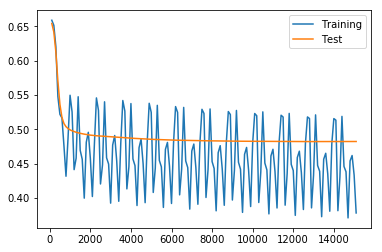

In [86]:
plt.plot(step_list,loss_list,label='Training')
plt.plot(step_list,test_list,label='Test')
plt.legend()

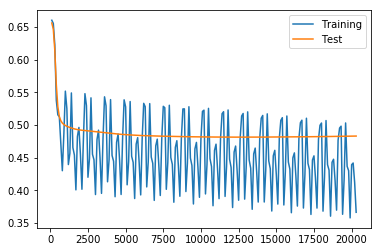

In [89]:
plt.plot(step_list,loss_list,label='Training')
plt.plot(step_list,test_list,label='Test')
plt.legend()

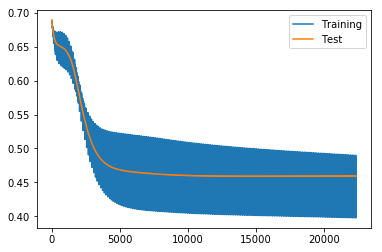

In [54]:
plt.plot(step_list,loss_list,label='Training')
plt.plot(step_list,test_list,label='Test')
plt.legend()

In [81]:
with tf.Session() as sess:                
    
    inputs = tf.placeholder(tf.float32,[None,vocab_size])
    labels = tf.placeholder(tf.float32,[None,1])
    lr = tf.placeholder(tf.float32)
    
    h1 = tf.contrib.layers.fully_connected(inputs,15,activation_fn=tf.nn.sigmoid)    
    out = tf.contrib.layers.fully_connected(h1,1,activation_fn=None)
    
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels,logits=out))
    opt = tf.train.AdadeltaOptimizer(learning_rate=lr).minimize(loss)        
    
    predic = tf.equal(tf.cast(tf.round(tf.sigmoid(out)),tf.int32),tf.cast(labels,tf.int32))
    accuracy = tf.reduce_mean(tf.cast(predic,tf.float32))
    
    sess.run(tf.global_variables_initializer())
    
    epoch = 2000
    step = 0    
    
    step_list =[]
    loss_list = []
    test_list = []
    
    _loss = 1
    
    for e in range(epoch):
        
        for batch in get_batches(enc,enc_X,enc_Y,enc_Z,y, 256):            
            if e< 500:
                _loss, _ = sess.run([loss,opt], feed_dict={inputs:batch[0],labels:batch[4],lr:0.1})
                t_loss = sess.run(loss,feed_dict={inputs:enc_test,labels:y_test})
                step +=1                         
            
            elif e >= 500:
                _loss, _ = sess.run([loss,opt], feed_dict={inputs:batch[0],labels:batch[4],lr:0.01})
                t_loss = sess.run(loss,feed_dict={inputs:enc_test,labels:y_test})
                step +=1                         
            
            if step % 100 ==0:
                step_list.append(step)
                loss_list.append(_loss)
                test_list.append(t_loss)
            
            if step % 100 ==0:
                acc = sess.run(accuracy,feed_dict={inputs:enc_test, labels:y_test})
                print('epoch: {} / {}'.format(e,epoch))
                print('steps : {}'.format(step))
                print('Training Loss : {}'.format(_loss))
                print('Test_Loss: {}'.format(t_loss))      
                print('Accuracy :{}'.format(acc))
                print()
            
plt.plot(step_list,loss_list,label='Training')
plt.plot(step_list,test_list,label='Test')
plt.legend()

epoch: 3 / 2000
steps : 100
Training Loss : 0.7216763496398926
Test_Loss: 0.7263574004173279
Accuracy :0.4005882441997528

epoch: 7 / 2000
steps : 200
Training Loss : 0.6941885948181152
Test_Loss: 0.6894211173057556
Accuracy :0.5267646908760071

epoch: 11 / 2000
steps : 300
Training Loss : 0.6581881642341614
Test_Loss: 0.6628541350364685
Accuracy :0.6135293841362

epoch: 15 / 2000
steps : 400
Training Loss : 0.6271570920944214
Test_Loss: 0.6442079544067383
Accuracy :0.6541176438331604

epoch: 19 / 2000
steps : 500
Training Loss : 0.6220411062240601
Test_Loss: 0.631195068359375
Accuracy :0.6682353019714355

epoch: 23 / 2000
steps : 600
Training Loss : 0.6146236062049866
Test_Loss: 0.6221941113471985
Accuracy :0.6735293865203857

epoch: 26 / 2000
steps : 700
Training Loss : 0.6039962768554688
Test_Loss: 0.6158499717712402
Accuracy :0.6761764883995056

epoch: 30 / 2000
steps : 800
Training Loss : 0.5903667211532593
Test_Loss: 0.6111875772476196
Accuracy :0.6726470589637756

epoch: 34 / 20

KeyboardInterrupt: 

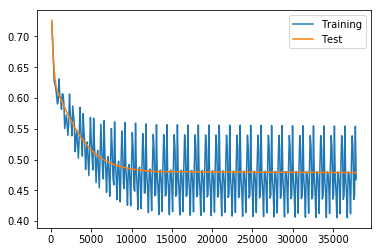

In [82]:
plt.plot(step_list,loss_list,label='Training')
plt.plot(step_list,test_list,label='Test')
plt.legend()

### Check features

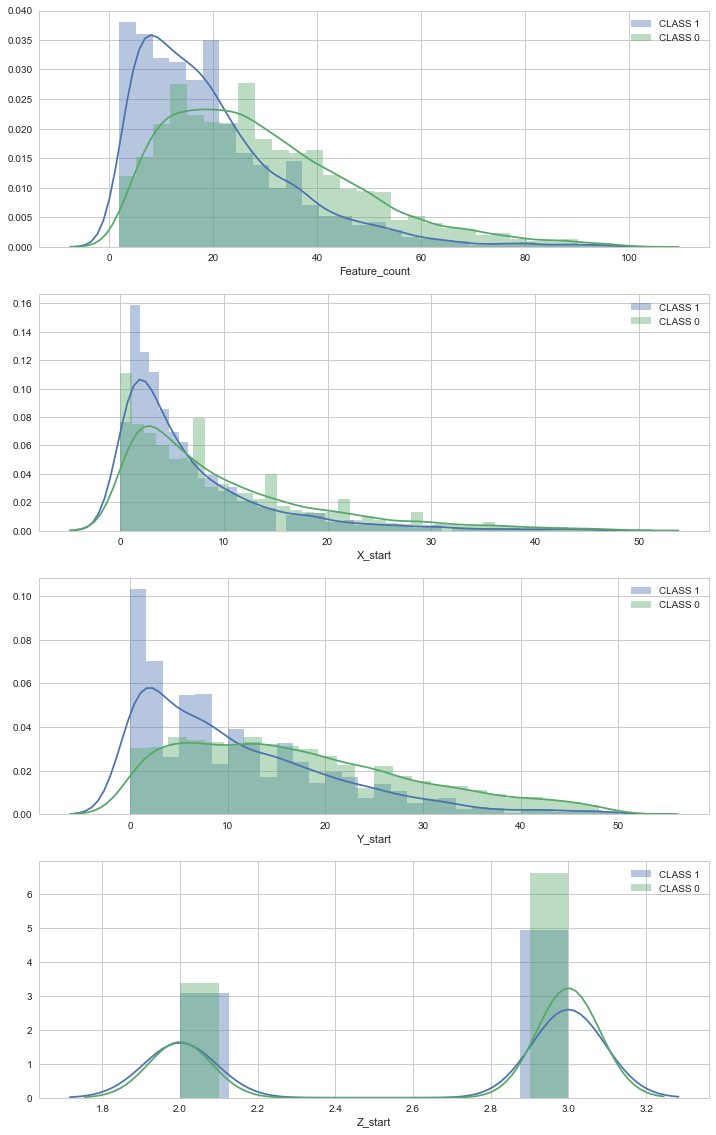

In [53]:
fig , ax = plt.subplots(4,1,figsize=(12,5*4))
ax_ = ax.flatten()

sns.distplot(data.Feature_count[data.Class==1],bins=30,label="CLASS 1", ax=ax_[0])
sns.distplot(data.Feature_count[data.Class==0],bins=30,label="CLASS 0", ax=ax_[0])
ax_[0].legend()

sns.distplot(data.X_start[data.Class==1],label='CLASS 1', ax= ax_[1])
sns.distplot(data.X_start[data.Class==0],label='CLASS 0', ax= ax_[1])
ax_[1].legend()

sns.distplot(data.Y_start[data.Class==1],label='CLASS 1', ax= ax_[2])
sns.distplot(data.Y_start[data.Class==0],label='CLASS 0', ax= ax_[2])
ax_[2].legend()

sns.distplot(data.Z_start[data.Class==1],label='CLASS 1', ax= ax_[3])
sns.distplot(data.Z_start[data.Class==0],label='CLASS 0', ax= ax_[3])
ax_[3].legend()


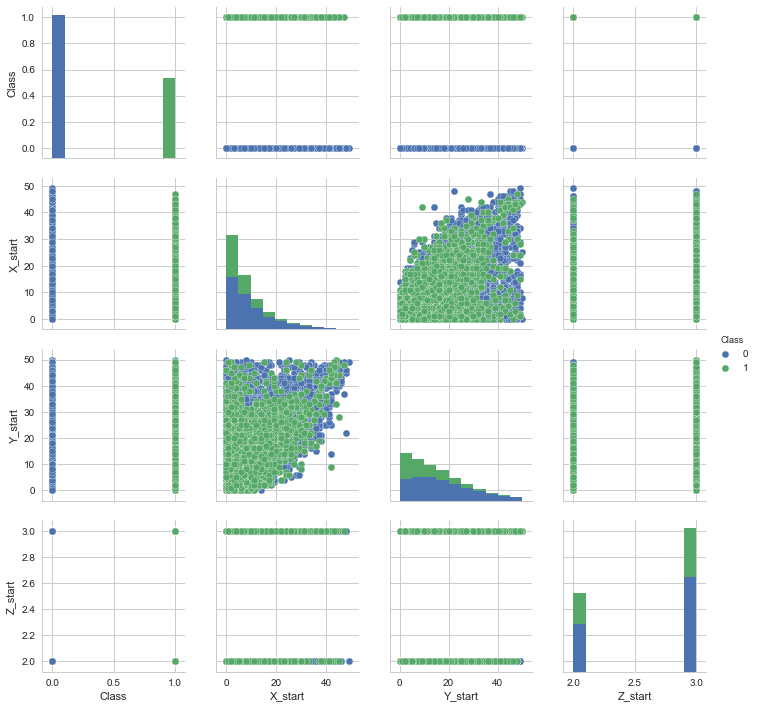

In [57]:
sns.pairplot(data[['Class','X_start','Y_start','Z_start']],hue='Class')

## Logistic Regression

## Deep Learning

#### ENC (LSTM,50) + One_hot(75) - > FC(125,64) -> FC(64,32) -> FC(32,2) -> Softmax 